In [1]:
from ngsolve import *
from ngsolve.meshes import MakeQuadMesh
from netgen.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csc_matrix

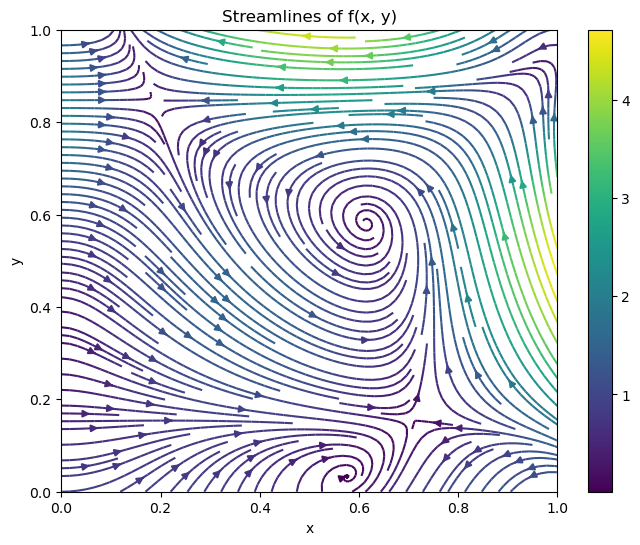

In [20]:
# Forcing term on Stokes equation
def f(x, y):
    f1 = -(12*x**2 - 12*x + 2)*(2*y - 8*y**3 +6*y**5) - (x**4 - 2*x**3 + x**2)*(-48*y + 120*y**3) + 1 - 2*x
    f2 = (12*y**2 - 12*y + 2)*(2*x - 8*x**3 +6*x**5) + (y**4 - 2*y**3 + y**2)*(-48*x + 120*x**3)
    return f1, f2

n = 100
X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))

F1, F2 = f(X, Y)
speed = np.sqrt(F1**2 + F2**2)

plt.figure(figsize=(8, 6))
plt.streamplot(X, Y, F1, F2, color=speed, cmap='viridis', density=2)
plt.colorbar()
plt.title("Streamlines of f(x, y)")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('tight')
plt.savefig('f_streamlines.png')
plt.show()

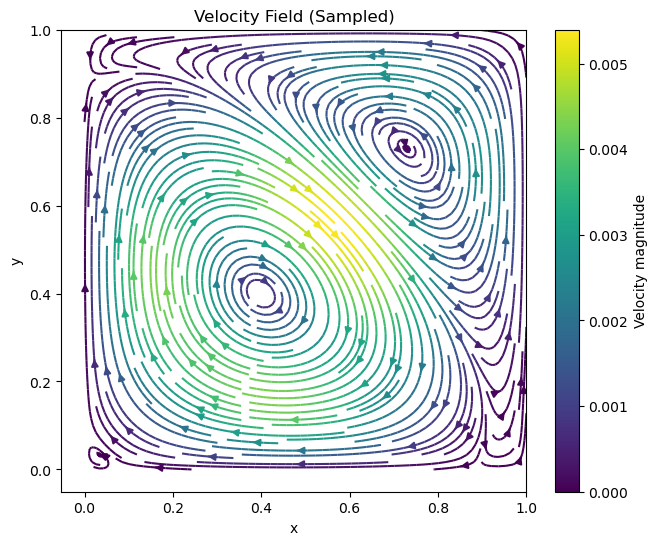

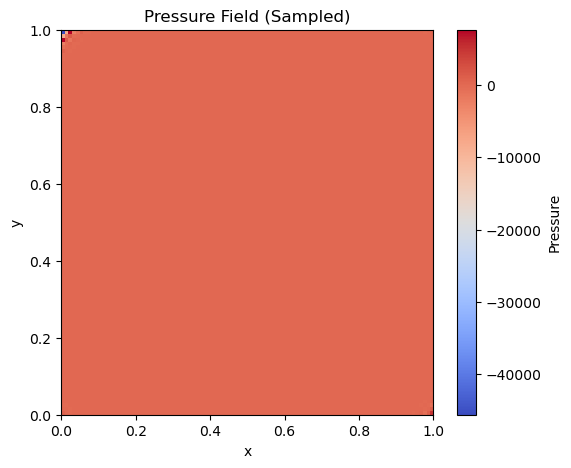

In [24]:
# Stokes equation P1/P1 without regularization
n = 64

mesh = MakeQuadMesh(n, n)

V = VectorH1(mesh, order=1, dirichlet=".*")
Q = H1(mesh, order=1)

X = V*Q

u, p = X.TrialFunction()
v, q = X.TestFunction()

stokes = InnerProduct(Grad(u), Grad(v))*dx - div(u)*q*dx + div(v)*p*dx
a = BilinearForm(stokes).Assemble()

# Exact solutions
u1_exact = x**2*(1-x)**2*(2*y-8*y**3+6*y**5)
u2_exact = -y**2*(1-y)**2*(2*x-8*x**3+6*x**5)
u_exact = CF((u1_exact, u2_exact))
p_exact = x*(1-x)

# Set boundary conditions
gf = GridFunction(X)
gfu, gfp = gf.components

gfu.Set(u_exact, definedon=mesh.Boundaries(".*"))

# Right hand side
f1 = -(u1_exact.Diff(x, 2) + u1_exact.Diff(y, 2)) + p_exact.Diff(x)
f2 = -(u2_exact.Diff(x, 2) + u2_exact.Diff(y, 2)) + p_exact.Diff(y)
f = CoefficientFunction((f1, f2))

l = LinearForm(X)
l += InnerProduct(f, v)*dx
l.Assemble()

# Solve
inv = a.mat.Inverse(X.FreeDofs())
gf.vec.data = inv * l.vec

N_plot = 100  # resolution for visualization
xs = np.linspace(0, 1, N_plot)
ys = np.linspace(0, 1, N_plot)
XX, YY = np.meshgrid(xs, ys)

vel_x = np.zeros((N_plot, N_plot))
vel_y = np.zeros((N_plot, N_plot))
p_vals = np.zeros((N_plot, N_plot))

for i in range(N_plot):
    for j in range(N_plot):
        xx, yy = XX[i, j], YY[i, j]
        vx, vy = gfu(xx, yy)
        vel_x[i, j] = vx
        vel_y[i, j] = vy
        p_vals[i, j] = gfp(xx, yy)

speed = np.sqrt(vel_x**2 + vel_y**2)

# === Plot Velocity Field ===
plt.figure(figsize=(7.5, 6))
plt.streamplot(xs, ys, vel_x, vel_y, color=speed, cmap='viridis', density=2)
plt.colorbar(label='Velocity magnitude')
plt.title("Velocity Field (Sampled)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('tight')
plt.savefig(f'stokes_u_{n}.png')
plt.show()

# === Plot Pressure Field ===
plt.figure(figsize=(6, 5))
plt.imshow(p_vals.T, origin='lower', extent=[0,1,0,1], cmap='coolwarm')
plt.colorbar(label='Pressure')
plt.title("Pressure Field (Sampled)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('tight')
plt.savefig(f'stokes_p_{n}.png')
plt.show()

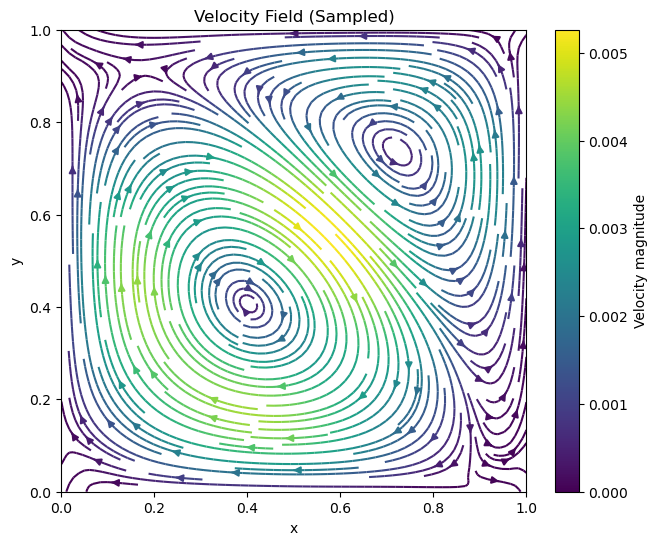

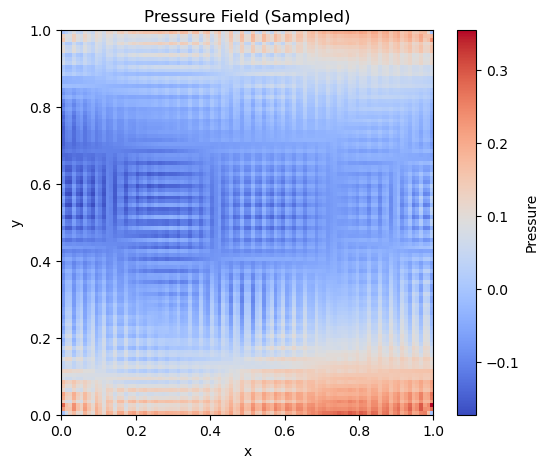

In [53]:
# Stokes equation P1/P1 with regulatization
n = 64
lam = 100

mesh = MakeQuadMesh(n, n)

V = VectorH1(mesh, order=1, dirichlet=".*")
Q = H1(mesh, order=1)

X = V*Q

u, p = X.TrialFunction()
v, q = X.TestFunction()

stokes = InnerProduct(Grad(u), Grad(v))*dx - div(u)*q*dx + div(v)*p*dx - 1/lam*p*q*dx
a = BilinearForm(stokes).Assemble()

# Exact solutions
u1_exact = x**2*(1-x)**2*(2*y-8*y**3+6*y**5)
u2_exact = -y**2*(1-y)**2*(2*x-8*x**3+6*x**5)
u_exact = CF((u1_exact, u2_exact))
p_exact = x*(1-x)

# Set boundary conditions
gf = GridFunction(X)
gfu, gfp = gf.components

gfu.Set(u_exact, definedon=mesh.Boundaries(".*"))

# Right hand side
f1 = -(u1_exact.Diff(x, 2) + u1_exact.Diff(y, 2)) + p_exact.Diff(x)
f2 = -(u2_exact.Diff(x, 2) + u2_exact.Diff(y, 2)) + p_exact.Diff(y)
f = CoefficientFunction((f1, f2))

l = LinearForm(X)
l += InnerProduct(f, v)*dx
l.Assemble()

# Solve
inv = a.mat.Inverse(X.FreeDofs())
gf.vec.data = inv * l.vec

N_plot = 100  # resolution for visualization
xs = np.linspace(0, 1, N_plot)
ys = np.linspace(0, 1, N_plot)
XX, YY = np.meshgrid(xs, ys)

vel_x = np.zeros((N_plot, N_plot))
vel_y = np.zeros((N_plot, N_plot))
p_vals = np.zeros((N_plot, N_plot))

for i in range(N_plot):
    for j in range(N_plot):
        xx, yy = XX[i, j], YY[i, j]
        vx, vy = gfu(xx, yy)
        vel_x[i, j] = vx
        vel_y[i, j] = vy
        p_vals[i, j] = gfp(xx, yy)

speed = np.sqrt(vel_x**2 + vel_y**2)

# === Plot Velocity Field ===
plt.figure(figsize=(7.5, 6))
plt.streamplot(xs, ys, vel_x, vel_y, color=speed, cmap='viridis', density=2)
plt.colorbar(label='Velocity magnitude')
plt.title("Velocity Field (Sampled)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('tight')
plt.savefig(f'stokes_u_{n}_lambda_{lam}.png')
plt.show()

# === Plot Pressure Field ===
plt.figure(figsize=(6, 5))
plt.imshow(p_vals.T, origin='lower', extent=[0,1,0,1], cmap='coolwarm')
plt.colorbar(label='Pressure')
plt.title("Pressure Field (Sampled)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('tight')
plt.savefig(f'stokes_p_{n}_lambda_{lam}.png')
plt.show()

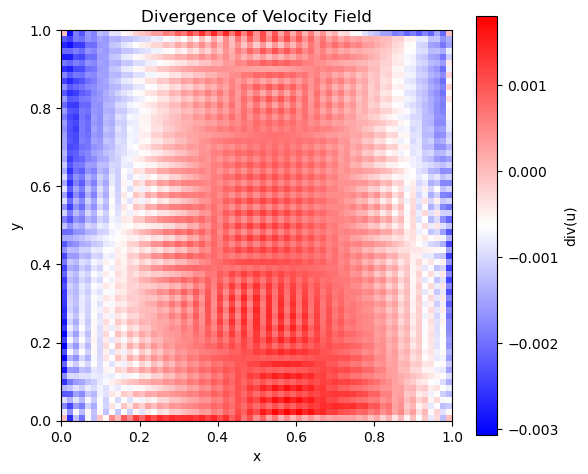

In [54]:
# Divergence of velocity field for P1/P1 stokes with divergence
W = H1(mesh, order=1)
div_u = GridFunction(W)

div_expr = div(gfu)
div_u.Set(div_expr)

div_vals = div_u.vec.FV().NumPy().reshape((n+1, n+1))

plt.figure(figsize=(6, 5))
plt.imshow(div_vals, origin='lower', extent=[0,1,0,1], cmap='bwr')
plt.colorbar(label='div(u)')
plt.title("Divergence of Velocity Field")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.savefig(f'div_u_lambda_{lam}.png')
plt.show()

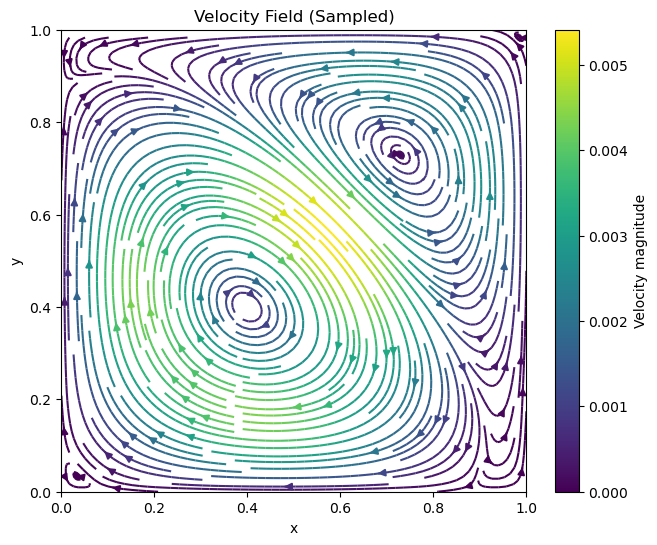

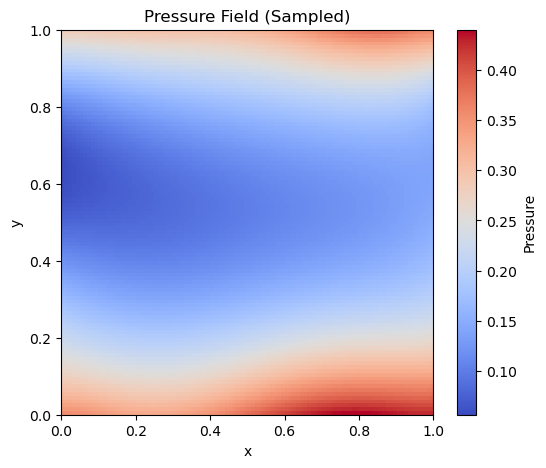

In [56]:
# Stokes with Taylor Hood, no regularization term
order = 2
n = 64

mesh = MakeQuadMesh(n, n)

V = VectorH1(mesh, order=order, dirichlet=".*")
Q = H1(mesh, order=order-1)

X = V*Q

u, p = X.TrialFunction()
v, q = X.TestFunction()

stokes = InnerProduct(Grad(u), Grad(v))*dx - div(u)*q*dx + div(v)*p*dx
a = BilinearForm(stokes).Assemble()

# Exact solutions
u1_exact = x**2*(1-x)**2*(2*y-8*y**3+6*y**5)
u2_exact = -y**2*(1-y)**2*(2*x-8*x**3+6*x**5)
u_exact = CF((u1_exact, u2_exact))
p_exact = x*(1-x)

# Set boundary conditions
gf = GridFunction(X)
gfu, gfp = gf.components

gfu.Set(u_exact, definedon=mesh.Boundaries(".*"))

# Right hand side
f1 = -(u1_exact.Diff(x, 2) + u1_exact.Diff(y, 2)) + p_exact.Diff(x)
f2 = -(u2_exact.Diff(x, 2) + u2_exact.Diff(y, 2)) + p_exact.Diff(y)
f = CoefficientFunction((f1, f2))

l = LinearForm(X)
l += InnerProduct(f, v)*dx
l.Assemble()

# Solve
inv = a.mat.Inverse(X.FreeDofs())
gf.vec.data = inv * l.vec

N_plot = 100  # resolution for visualization
xs = np.linspace(0, 1, N_plot)
ys = np.linspace(0, 1, N_plot)
XX, YY = np.meshgrid(xs, ys)

vel_x = np.zeros((N_plot, N_plot))
vel_y = np.zeros((N_plot, N_plot))
p_vals = np.zeros((N_plot, N_plot))


for i in range(N_plot):
    for j in range(N_plot):
        xx, yy = XX[i, j], YY[i, j]
        vx, vy = gfu(xx, yy)
        vel_x[i, j] = vx
        vel_y[i, j] = vy
        p_vals[i, j] = gfp(xx, yy)

speed = np.sqrt(vel_x**2 + vel_y**2)

# === Plot Velocity Field ===
plt.figure(figsize=(7.5, 6))
plt.streamplot(xs, ys, vel_x, vel_y, color=speed, cmap='viridis', density=2)
plt.colorbar(label='Velocity magnitude')
plt.title("Velocity Field (Sampled)")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(f'TH_u_{n}')
plt.axis('tight')
plt.show()

# === Plot Pressure Field ===
plt.figure(figsize=(6, 5))
plt.imshow(p_vals.T, origin='lower', extent=[0,1,0,1], cmap='coolwarm')
plt.colorbar(label='Pressure')
plt.title("Pressure Field (Sampled)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('tight')
plt.savefig(f'TH_p_{n}')
plt.show()

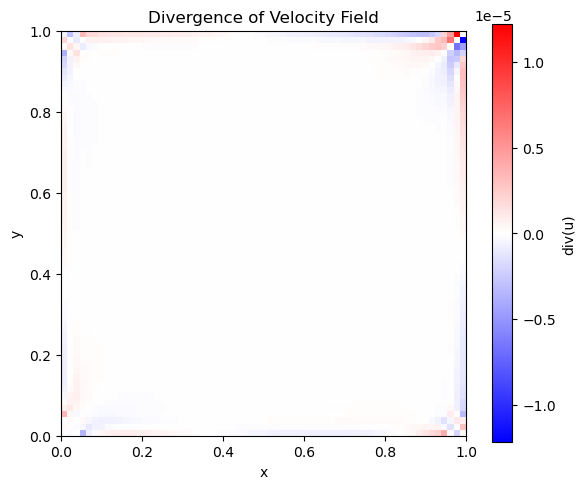

In [57]:
# Divergence of velocity field for P1/P1 stokes with divergence
W = H1(mesh, order=1)
div_u = GridFunction(W)

div_expr = div(gfu)
div_u.Set(div_expr)

div_vals = div_u.vec.FV().NumPy().reshape((n+1, n+1))

plt.figure(figsize=(6, 5))
plt.imshow(div_vals, origin='lower', extent=[0,1,0,1], cmap='bwr')
plt.colorbar(label='div(u)')
plt.title("Divergence of Velocity Field")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.savefig(f'TH_divu_{n}')
plt.show()